In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import caselawnet
import numpy as np
import community

[nltk_data] Downloading package punkt to /home/dafne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
filepath = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/'
links_sub = pd.read_csv(os.path.join(filepath, 'subnetwork', 'case-to-case-links.csv'))
cases_sub = pd.read_csv(os.path.join(filepath, 'subnetwork', 'case-nodes-sub.csv'))

In [5]:
cases_sub.head()

,ecli,lido_id,country,court,year,id,label,node_type
0,ECLI:NL:CRVB:2016:2999,http://linkeddata.overheid.nl/terms/jurisprude...,NL,CRVB,2016.0,http://linkeddata.overheid.nl/terms/jurisprude...,CRVB:2016,0
1,ECLI:NL:RBROT:2013:BZ2568,http://linkeddata.overheid.nl/terms/jurisprude...,NL,RBROT,2013.0,http://linkeddata.overheid.nl/terms/jurisprude...,RBROT:2013,0
2,ECLI:NL:GHAMS:2011:BU6149,http://linkeddata.overheid.nl/terms/jurisprude...,NL,GHAMS,2011.0,http://linkeddata.overheid.nl/terms/jurisprude...,GHAMS:2011,0
3,ECLI:NL:GHARL:2014:6359,http://linkeddata.overheid.nl/terms/jurisprude...,NL,GHARL,2014.0,http://linkeddata.overheid.nl/terms/jurisprude...,GHARL:2014,0
4,ECLI:NL:RBNHO:2017:5966,http://linkeddata.overheid.nl/terms/jurisprude...,NL,RBNHO,2017.0,http://linkeddata.overheid.nl/terms/jurisprude...,RBNHO:2017,0


In [3]:
cases_sub_list = cases_sub.rename_axis({'link_id':'id'}, axis=1).to_dict(orient='records')
links_sub_list = links_sub.rename_axis({'link_id':'id'}, axis=1).to_dict(orient='records')

In [4]:
graph = nx.readwrite.json_graph.node_link_graph({'nodes': cases_sub_list, 'links': links_sub_list}, directed=True, multigraph=False)

In [5]:
graph.number_of_nodes(), graph.number_of_edges()

(1596, 1608)

In [6]:
ccs = list(nx.weakly_connected_components(graph))
ccs_sizes = [len(cc) for cc in ccs]
gcc = ccs[np.argmax(ccs_sizes)]
g_gcc = graph.subgraph(gcc)

In [7]:
g_gcc.number_of_nodes(), g_gcc.number_of_edges()

(615, 1225)

In [8]:
resolution_range = np.arange(0.5, 2, 0.1)
nr_communities = np.zeros(len(resolution_range))
modularities = np.zeros(len(resolution_range))
for i in range(len(resolution_range)):
    partition = community.best_partition(g_gcc.to_undirected(), resolution=resolution_range[i])
    nr_communities[i] = len(set(partition.values()))
    modularities[i] = community.modularity(partition, g_gcc.to_undirected())

/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


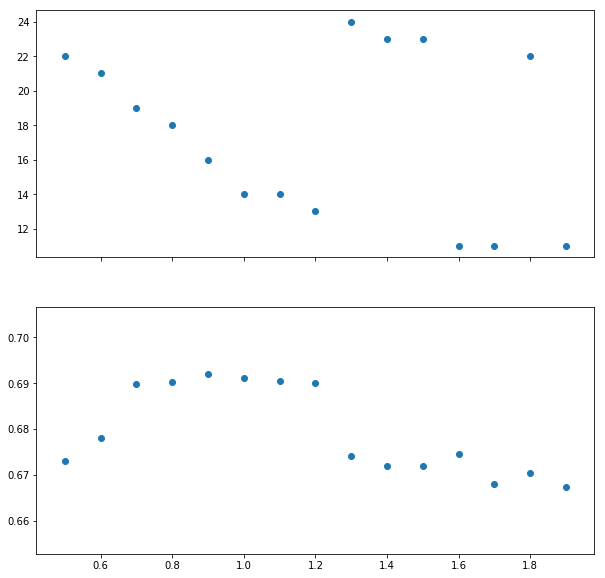

In [9]:
plt, axes = plt.subplots(2, sharex=True, figsize=(10,10))
axes[0].scatter(resolution_range, nr_communities)
axes[1].scatter(resolution_range, modularities)

plt.show()

In [10]:
def draw_communities(G, partition, pos=None):
    size = len(set(partition.values()))
    if pos is None:
        pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count += 1.
        list_nodes = [nodes for nodes in partition.keys()
                                 if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = [count / size]*len(list_nodes), cmap='rainbow', vmin=0, vmax=1)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.gca().set_title('{} communities'.format(size))
    plt.axis('off')
    plt.show()

In [11]:
com_df = pd.DataFrame()
pos = nx.spring_layout(g_gcc, random_state=1, iterations=200, k=3)
for resolution in [0.5, 0.8, 1.0, 1.6]:
    print(resolution)
    partition = community.best_partition(g_gcc.to_undirected(), resolution=resolution)
    #draw_communities(g_gcc, partition, pos)
    nx.set_node_attributes(g_gcc, partition, name='com_{:.1f}'.format(resolution))
    com_df['com_{:.1f}'.format(resolution)] = pd.Series(partition)

0.5
0.8
1.0
1.6


In [10]:
com_df.nunique()

NameError: name 'com_df' is not defined

In [12]:
nx.write_gexf(g_gcc, os.path.join(filepath, 'subnetwork', 'network.gexf'))

In [ ]:
g_gcc.nodes.data()['http://linkeddata.overheid.nl/terms/jurisprudentie/id/ECLI:NL:HR:2008:BG7775']